# Meeting arrival times - an example notebook
This notebook provides an example of combining a mean-field game (MFG) with neural ordinary differential equations (ODEs). In particular, we will consider a distribution of agents arriving at a meeting; an example introduced in the book “Mean Field Games and Applications” by Olivier Guéant, Jean-Michel Lasry and Pierre-Louis Lions (p. 9; available [here](https://www.oliviergueant.com/uploads/4/3/0/9/4309511/paris-princeton.pdf)). 

**The game is defined as follows**: A meeting is scheduled for a certain time $t$, but only starts after a certain percentile of players has arrived. The actual starting time is represented by $T$. Each player $i$ has their own arrival time, $\tilde{\tau}_i = \tau_i + \epsilon_i$, where $\tau_i$ is the planned arrival time of player $i$ and $\epsilon_i$ is the noise associated with that planning. Given the three times, $t$, $\tau_i$ and $T$, each player $i$ aims to minimize the cost associated with being too early or too late to the meeting.

**In this notebook**, we will first generate a distribution of arrival times. Next, we initialize the game and run an example using the standard MFG theory. Lastly, we show how to combine the MFG with a neural ODE, run the game and compare the results.  


In [1]:
# imports
import time
import numpy as np

import jax.random as jrandom
from diffrax import diffeqsolve, Euler, MultiTerm, SaveAt

from games.meeting_arrival_times.MeetingTime import MeetingTime
from games.meeting_arrival_times.arrival_times_data import generate_arrival_times, plot_arrival_times
from games.meeting_arrival_times.arrival_times_nODE import make_step, grad_loss
from games.meeting_arrival_times.arrival_times_example import game_boxplots

from games.meeting_arrival_times.neuralODE import NeuralODE, dataloader

import optax
import equinox as eqx
from diffrax import ControlTerm, ODETerm, VirtualBrownianTree

## Generating arrival times
When neural ODEs are considered, we need labels to train on. Yet, even without nODEs, there's a need for an initial distribution of arrival times $\tilde{\tau}$ to kick off the game. This initial distribution of meeting times $y_0$ is drawn from a Gaussian with $\mu=12$ and $\sigma = 0.5$. The initial distribution is _the same for each game_.


 When nODEs are involved, we also need data to train on. This data is generated according to the model described in the figure generated with the code below. The data represent the outcomes of the games at turn 15 and differs between the games. Having $N=6$ generative distributions and $M=7$ players per distribution, there are 42 players in the game. The graphical (left) and generative (right) model of the data generation is shown below. 
 
![The graphical and generative model of the data generation](./figures/data_generation.png)
 
The data are generated in `arrival_times_data.py`. This file can be run separately to generate a figure of the generation process. However, we've imported the functionality here to render the figures in the notebook itself. 

 

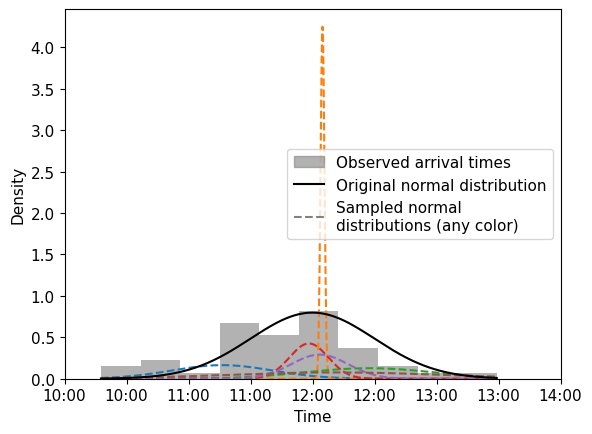

In [2]:
N = 6  # Number of distributions to sample from
M = 7  # Number of samples per distribution

mu = 12  # The official starting time of the meeting
sigma = 0.5  # Starting time noise (perhaps due to incomplete communication)

k = 2
theta = 0.2

mu_i, sigma_i, x_j = generate_arrival_times(mu, sigma, k, theta, N, M)
plot_arrival_times(x_j, mu, sigma, mu_i, sigma_i, save=False)

## Playing the standard arrival times mean-field game
The standard MFG does not include neural ODEs, and does therefore not train towards the distribution generated above. Instead, it aims to produce a narrow distribution of arrival times, centered around the start of the meeting. In the results, shown below, we see that deviation of arrival times quickly shrinks. The exact time of arrival drifts, this is because of the **Brownian motion** that is included in the stochastic differential equation (SDE) describing the meeting time arrival dynamics (`terms`). 

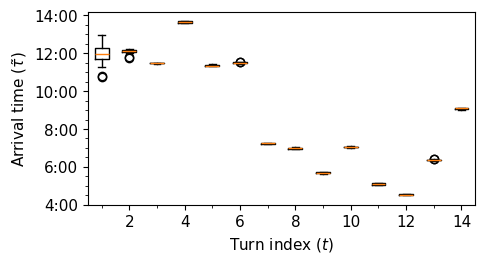

In [3]:
# Set the minimal number of agents required for the meeting to start
threshold = 0.8

# Generate initial distribution
initial_distribution = np.random.normal(mu, sigma, size=N * M)

# Initialize meeting
t0 = 1
t1 = 15
meeting = MeetingTime(mu, threshold)
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jrandom.PRNGKey(0))
terms = MultiTerm(ODETerm(meeting.drift), ControlTerm(meeting.diffusion, brownian_motion))

solver = Euler()
save_range = np.arange(t0, t1, 1)
saveat = SaveAt(ts=save_range)
sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=initial_distribution, saveat=saveat)

game_boxplots(sol.ys, None, legend=False)

## Extending the arrival times mean-field game with a neural ODE

While the game described above converges to some kind of equilibrium (if not for the Brownian noise), the mechanics are not **data-driven**. To contrast this, we add a neural network to the SDE to train towards a target distribution of meeting times, effectively recovering the structure used to produce the target distribution. 

In this case, we train towards a distribution centered at 15:00 (indicated with the red horizontal line). As such, the neural ODE has to transform the initial distribution at turn 1, centered around 12:00, towards the target at turn 15. This transition takes place alongside the game dynamics, as each player still has to adhere to the rules of the game. In addition, the neural ODE accounts for the Brownian noise, which causes the distribution to drift in turns 2-14. 

The loss is merely calculated based on the distribution at turn 15, allowing the agents to drift in between. 

Step: 0, train loss: 15.3813, computation time: 2.199s	- validation loss: 14.7495
Step: 100, train loss: 1.0205, computation time: 0.007s	- validation loss: 0.9708
Step: 200, train loss: 0.6510, computation time: 0.006s	- validation loss: 0.7642
Step: 300, train loss: 0.6492, computation time: 0.006s	- validation loss: 0.7477
Step: 400, train loss: 0.6354, computation time: 0.006s	- validation loss: 0.7443
Step: 499, train loss: 0.6594, computation time: 0.006s	- validation loss: 0.7412


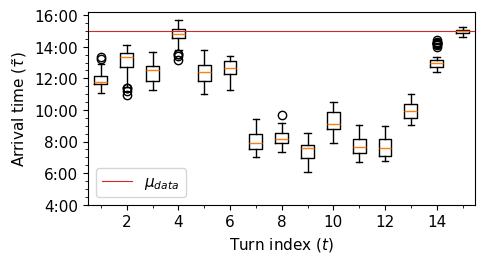

In [4]:
dataset_size = 1000
batch_size = 32
lr = 5e-4
steps = 500
print_every = 100

# Target distribution
target_mu = 15
target_sigma = 0.5

# Generate data
ys = np.array([generate_arrival_times(target_mu, target_sigma, 2, 0.2, N, M)[-1] for _ in range(dataset_size)])
ys_validation = np.array([generate_arrival_times(target_mu, target_sigma, 2, 0.2, N, M)[-1] for _ in range(10)])

# Initialize meeting
t0 = 1
t1 = 15
ts = np.linspace(1, 15, 15)
meeting = MeetingTime(mu, threshold)
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jrandom.PRNGKey(0))
drift = ODETerm(meeting.drift)
diffusion = ControlTerm(meeting.diffusion, brownian_motion)

# Generate initial distribution
y0 = np.random.normal(mu, sigma, size=N * M)

# Create neuralODE
key = jrandom.PRNGKey(42)
data_key, model_key, loader_key = jrandom.split(key, 3)
model = NeuralODE(N * M, 8, 3, drift, diffusion, key=model_key)

optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

# Train loop
train_loss = np.zeros(steps)
validation_loss = np.zeros(steps)

for i, (step, yi) in enumerate(zip(range(steps), dataloader(ys, batch_size, key=loader_key))):
    start = time.time()
    train_loss[i], model, opt_state = make_step(ts, y0, yi, model, optim, opt_state, grad_loss)
    end = time.time()

    validation_loss[i], _ = grad_loss(model, ts, y0, ys_validation)

    if (step % print_every) == 0 or step == steps - 1:
        print(f"Step: {step}, train loss: {train_loss[i]:.4f}, computation time: {(end - start):.3f}s"
              f"\t- validation loss: {validation_loss[i]:.4f}")


model_ys = model(ts, y0)
game_boxplots(model_ys, None, target_mu)